In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='75'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/profiles-v2-pca'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
INPUT_PT_PATH = f"/workspace/profiles-v2-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037/density_plot.png


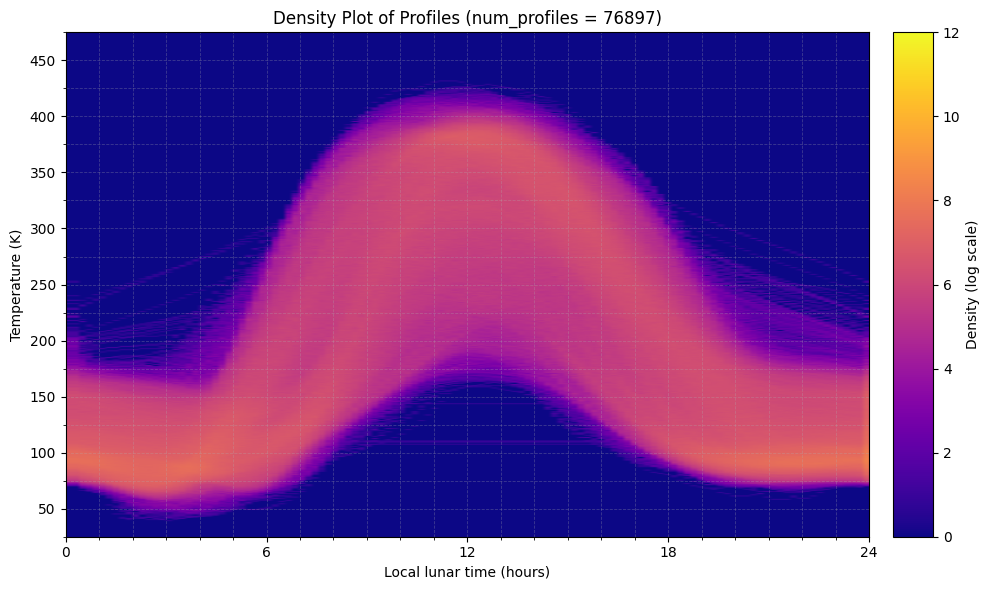

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 190.3739
STD: 94.5655
Min Temp: 40.0240
Max Temp: 431.4890
Datasets:
Training Data: 53827
Validation Data: 15379
Test Data: 7691


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 270/270 [00:08<00:00, 31.75it/s, best_loss=0.6385]


[Training] Epoch 1/100, L1 Loss: 0.6634, L2 Loss: 0.6810, KL Loss: 0.4096, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 77/77 [00:00<00:00, 98.96it/s] 


[Validation] Epoch 1/100, Val L1 Loss: 0.5849, Val L2 Loss: 0.5691, Val KL Loss: 0.5056
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037'


[Training] Epoch 2/100: 100%|██████████| 270/270 [00:08<00:00, 31.44it/s, best_loss=0.6030]


[Training] Epoch 2/100, L1 Loss: 0.6079, L2 Loss: 0.5946, KL Loss: 0.5031, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 77/77 [00:00<00:00, 97.78it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5836, Val L2 Loss: 0.5665, Val KL Loss: 0.4961
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037'


[Training] Epoch 3/100: 100%|██████████| 270/270 [00:08<00:00, 31.22it/s, best_loss=0.6082]


[Training] Epoch 3/100, L1 Loss: 0.6057, L2 Loss: 0.5923, KL Loss: 0.5093, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 77/77 [00:00<00:00, 98.16it/s] 


[Validation] Epoch 3/100, Val L1 Loss: 0.5782, Val L2 Loss: 0.5616, Val KL Loss: 0.5141
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037'


[Training] Epoch 4/100: 100%|██████████| 270/270 [00:08<00:00, 31.33it/s, best_loss=0.6062]


[Training] Epoch 4/100, L1 Loss: 0.6049, L2 Loss: 0.5910, KL Loss: 0.5104, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 77/77 [00:00<00:00, 99.24it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5769, Val L2 Loss: 0.5609, Val KL Loss: 0.5164
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037'


[Training] Epoch 5/100: 100%|██████████| 270/270 [00:08<00:00, 31.42it/s, best_loss=0.6032]


[Training] Epoch 5/100, L1 Loss: 0.6049, L2 Loss: 0.5908, KL Loss: 0.5106, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 77/77 [00:00<00:00, 105.74it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5768, Val L2 Loss: 0.5605, Val KL Loss: 0.5132
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037'


[Training] Epoch 6/100: 100%|██████████| 270/270 [00:08<00:00, 31.39it/s, best_loss=0.5975]


[Training] Epoch 6/100, L1 Loss: 0.6048, L2 Loss: 0.5906, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 77/77 [00:00<00:00, 101.76it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5799, Val L2 Loss: 0.5632, Val KL Loss: 0.5086


[Training] Epoch 7/100: 100%|██████████| 270/270 [00:08<00:00, 30.84it/s, best_loss=0.5895]


[Training] Epoch 7/100, L1 Loss: 0.6055, L2 Loss: 0.5920, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 77/77 [00:00<00:00, 101.69it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5794, Val L2 Loss: 0.5627, Val KL Loss: 0.5032


[Training] Epoch 8/100: 100%|██████████| 270/270 [00:08<00:00, 31.38it/s, best_loss=0.5859]


[Training] Epoch 8/100, L1 Loss: 0.6055, L2 Loss: 0.5921, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 77/77 [00:00<00:00, 99.49it/s] 


[Validation] Epoch 8/100, Val L1 Loss: 0.5768, Val L2 Loss: 0.5606, Val KL Loss: 0.5112


[Training] Epoch 9/100: 100%|██████████| 270/270 [00:08<00:00, 30.70it/s, best_loss=0.5855]


[Training] Epoch 9/100, L1 Loss: 0.6047, L2 Loss: 0.5905, KL Loss: 0.5106, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 77/77 [00:00<00:00, 103.27it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5798, Val L2 Loss: 0.5632, Val KL Loss: 0.5072


[Training] Epoch 10/100: 100%|██████████| 270/270 [00:08<00:00, 30.81it/s, best_loss=0.5729]


[Training] Epoch 10/100, L1 Loss: 0.6049, L2 Loss: 0.5909, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 77/77 [00:00<00:00, 99.92it/s] 


[Validation] Epoch 10/100, Val L1 Loss: 0.5764, Val L2 Loss: 0.5603, Val KL Loss: 0.5198
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037'


[Training] Epoch 11/100: 100%|██████████| 270/270 [00:08<00:00, 30.68it/s, best_loss=0.5990]


[Training] Epoch 11/100, L1 Loss: 0.6049, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 77/77 [00:00<00:00, 100.77it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5767, Val L2 Loss: 0.5607, Val KL Loss: 0.5120


[Training] Epoch 12/100: 100%|██████████| 270/270 [00:08<00:00, 31.42it/s, best_loss=0.5843]


[Training] Epoch 12/100, L1 Loss: 0.6052, L2 Loss: 0.5915, KL Loss: 0.5103, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 77/77 [00:00<00:00, 97.53it/s] 


[Validation] Epoch 12/100, Val L1 Loss: 0.5770, Val L2 Loss: 0.5607, Val KL Loss: 0.5138


[Training] Epoch 13/100: 100%|██████████| 270/270 [00:08<00:00, 31.22it/s, best_loss=0.5936]


[Training] Epoch 13/100, L1 Loss: 0.6048, L2 Loss: 0.5909, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 77/77 [00:00<00:00, 99.32it/s] 


[Validation] Epoch 13/100, Val L1 Loss: 0.5807, Val L2 Loss: 0.5639, Val KL Loss: 0.5066


[Training] Epoch 14/100: 100%|██████████| 270/270 [00:08<00:00, 31.83it/s, best_loss=0.6095]


[Training] Epoch 14/100, L1 Loss: 0.6050, L2 Loss: 0.5907, KL Loss: 0.5106, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 77/77 [00:00<00:00, 106.14it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5798, Val L2 Loss: 0.5632, Val KL Loss: 0.5046


[Training] Epoch 15/100: 100%|██████████| 270/270 [00:08<00:00, 31.69it/s, best_loss=0.5980]


[Training] Epoch 15/100, L1 Loss: 0.6044, L2 Loss: 0.5903, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 77/77 [00:00<00:00, 102.11it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5790, Val L2 Loss: 0.5627, Val KL Loss: 0.5131


[Training] Epoch 16/100: 100%|██████████| 270/270 [00:08<00:00, 31.07it/s, best_loss=0.5996]


[Training] Epoch 16/100, L1 Loss: 0.6044, L2 Loss: 0.5904, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 77/77 [00:00<00:00, 101.50it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5753, Val L2 Loss: 0.5594, Val KL Loss: 0.5196
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037'


[Training] Epoch 17/100: 100%|██████████| 270/270 [00:08<00:00, 31.47it/s, best_loss=0.5779]


[Training] Epoch 17/100, L1 Loss: 0.6049, L2 Loss: 0.5909, KL Loss: 0.5106, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 77/77 [00:00<00:00, 96.21it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5770, Val L2 Loss: 0.5607, Val KL Loss: 0.5108


[Training] Epoch 18/100: 100%|██████████| 270/270 [00:08<00:00, 30.63it/s, best_loss=0.5881]


[Training] Epoch 18/100, L1 Loss: 0.6046, L2 Loss: 0.5905, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 77/77 [00:00<00:00, 97.82it/s] 


[Validation] Epoch 18/100, Val L1 Loss: 0.5789, Val L2 Loss: 0.5625, Val KL Loss: 0.5135


[Training] Epoch 19/100: 100%|██████████| 270/270 [00:08<00:00, 31.47it/s, best_loss=0.6126]


[Training] Epoch 19/100, L1 Loss: 0.6049, L2 Loss: 0.5909, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 77/77 [00:00<00:00, 110.60it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5797, Val L2 Loss: 0.5630, Val KL Loss: 0.5067


[Training] Epoch 20/100: 100%|██████████| 270/270 [00:08<00:00, 31.04it/s, best_loss=0.6069]


[Training] Epoch 20/100, L1 Loss: 0.6050, L2 Loss: 0.5913, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 77/77 [00:00<00:00, 101.81it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5769, Val L2 Loss: 0.5608, Val KL Loss: 0.5144


[Training] Epoch 21/100: 100%|██████████| 270/270 [00:08<00:00, 30.90it/s, best_loss=0.6024]


[Training] Epoch 21/100, L1 Loss: 0.6050, L2 Loss: 0.5910, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 77/77 [00:00<00:00, 97.82it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5770, Val L2 Loss: 0.5611, Val KL Loss: 0.5154


[Training] Epoch 22/100: 100%|██████████| 270/270 [00:08<00:00, 30.86it/s, best_loss=0.6143]


[Training] Epoch 22/100, L1 Loss: 0.6057, L2 Loss: 0.5924, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 77/77 [00:00<00:00, 104.58it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5759, Val L2 Loss: 0.5601, Val KL Loss: 0.5192


[Training] Epoch 23/100: 100%|██████████| 270/270 [00:08<00:00, 31.01it/s, best_loss=0.5956]


[Training] Epoch 23/100, L1 Loss: 0.6051, L2 Loss: 0.5914, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 77/77 [00:00<00:00, 109.17it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5800, Val L2 Loss: 0.5631, Val KL Loss: 0.5030


[Training] Epoch 24/100: 100%|██████████| 270/270 [00:08<00:00, 31.32it/s, best_loss=0.5951]


[Training] Epoch 24/100, L1 Loss: 0.6047, L2 Loss: 0.5907, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 77/77 [00:00<00:00, 101.36it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5777, Val L2 Loss: 0.5615, Val KL Loss: 0.5147


[Training] Epoch 25/100: 100%|██████████| 270/270 [00:08<00:00, 32.31it/s, best_loss=0.5856]


[Training] Epoch 25/100, L1 Loss: 0.6042, L2 Loss: 0.5899, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 77/77 [00:00<00:00, 112.81it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5770, Val L2 Loss: 0.5607, Val KL Loss: 0.5141


[Training] Epoch 26/100: 100%|██████████| 270/270 [00:08<00:00, 31.95it/s, best_loss=0.6061]


[Training] Epoch 26/100, L1 Loss: 0.6052, L2 Loss: 0.5915, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 77/77 [00:00<00:00, 105.65it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5741, Val L2 Loss: 0.5587, Val KL Loss: 0.5239
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_75_20250720_2037'


[Training] Epoch 27/100: 100%|██████████| 270/270 [00:08<00:00, 31.44it/s, best_loss=0.6009]


[Training] Epoch 27/100, L1 Loss: 0.6049, L2 Loss: 0.5913, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 77/77 [00:00<00:00, 111.04it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5799, Val L2 Loss: 0.5632, Val KL Loss: 0.5054


[Training] Epoch 28/100: 100%|██████████| 270/270 [00:08<00:00, 31.33it/s, best_loss=0.5895]


[Training] Epoch 28/100, L1 Loss: 0.6043, L2 Loss: 0.5903, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 77/77 [00:00<00:00, 101.27it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5784, Val L2 Loss: 0.5621, Val KL Loss: 0.5105


[Training] Epoch 29/100: 100%|██████████| 270/270 [00:08<00:00, 31.61it/s, best_loss=0.5944]


[Training] Epoch 29/100, L1 Loss: 0.6046, L2 Loss: 0.5905, KL Loss: 0.5106, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 77/77 [00:00<00:00, 92.26it/s] 


[Validation] Epoch 29/100, Val L1 Loss: 0.5774, Val L2 Loss: 0.5609, Val KL Loss: 0.5106


[Training] Epoch 30/100: 100%|██████████| 270/270 [00:08<00:00, 31.09it/s, best_loss=0.6023]


[Training] Epoch 30/100, L1 Loss: 0.6041, L2 Loss: 0.5900, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 77/77 [00:00<00:00, 99.15it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5787, Val L2 Loss: 0.5623, Val KL Loss: 0.5105


[Training] Epoch 31/100: 100%|██████████| 270/270 [00:08<00:00, 31.49it/s, best_loss=0.5870]


[Training] Epoch 31/100, L1 Loss: 0.6054, L2 Loss: 0.5916, KL Loss: 0.5103, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 77/77 [00:00<00:00, 108.07it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5754, Val L2 Loss: 0.5595, Val KL Loss: 0.5194


[Training] Epoch 32/100: 100%|██████████| 270/270 [00:08<00:00, 30.53it/s, best_loss=0.5880]


[Training] Epoch 32/100, L1 Loss: 0.6048, L2 Loss: 0.5911, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 77/77 [00:00<00:00, 95.51it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5754, Val L2 Loss: 0.5595, Val KL Loss: 0.5147


[Training] Epoch 33/100: 100%|██████████| 270/270 [00:08<00:00, 31.03it/s, best_loss=0.5977]


[Training] Epoch 33/100, L1 Loss: 0.6048, L2 Loss: 0.5907, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 77/77 [00:00<00:00, 107.13it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5795, Val L2 Loss: 0.5630, Val KL Loss: 0.5113


[Training] Epoch 34/100: 100%|██████████| 270/270 [00:09<00:00, 29.44it/s, best_loss=0.6033]


[Training] Epoch 34/100, L1 Loss: 0.6047, L2 Loss: 0.5908, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 77/77 [00:00<00:00, 98.99it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5769, Val L2 Loss: 0.5608, Val KL Loss: 0.5145


[Training] Epoch 35/100: 100%|██████████| 270/270 [00:08<00:00, 30.97it/s, best_loss=0.5931]


[Training] Epoch 35/100, L1 Loss: 0.6046, L2 Loss: 0.5906, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 77/77 [00:00<00:00, 100.16it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5775, Val L2 Loss: 0.5613, Val KL Loss: 0.5103


[Training] Epoch 36/100: 100%|██████████| 270/270 [00:08<00:00, 30.86it/s, best_loss=0.5822]


[Training] Epoch 36/100, L1 Loss: 0.6042, L2 Loss: 0.5901, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 77/77 [00:00<00:00, 107.50it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5786, Val L2 Loss: 0.5620, Val KL Loss: 0.5106


[Training] Epoch 37/100: 100%|██████████| 270/270 [00:08<00:00, 30.74it/s, best_loss=0.5886]


[Training] Epoch 37/100, L1 Loss: 0.6053, L2 Loss: 0.5916, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 77/77 [00:00<00:00, 108.53it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5768, Val L2 Loss: 0.5607, Val KL Loss: 0.5123


[Training] Epoch 38/100: 100%|██████████| 270/270 [00:08<00:00, 31.05it/s, best_loss=0.6106]


[Training] Epoch 38/100, L1 Loss: 0.6052, L2 Loss: 0.5912, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 77/77 [00:00<00:00, 102.09it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5793, Val L2 Loss: 0.5625, Val KL Loss: 0.5081


[Training] Epoch 39/100: 100%|██████████| 270/270 [00:08<00:00, 31.74it/s, best_loss=0.5899]


[Training] Epoch 39/100, L1 Loss: 0.6053, L2 Loss: 0.5918, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 77/77 [00:00<00:00, 100.28it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5785, Val L2 Loss: 0.5620, Val KL Loss: 0.5052


[Training] Epoch 40/100: 100%|██████████| 270/270 [00:08<00:00, 31.75it/s, best_loss=0.5823]


[Training] Epoch 40/100, L1 Loss: 0.6044, L2 Loss: 0.5904, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 77/77 [00:00<00:00, 106.37it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5803, Val L2 Loss: 0.5637, Val KL Loss: 0.5123


[Training] Epoch 41/100: 100%|██████████| 270/270 [00:08<00:00, 30.60it/s, best_loss=0.5977]


[Training] Epoch 41/100, L1 Loss: 0.6050, L2 Loss: 0.5909, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 77/77 [00:00<00:00, 102.43it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5782, Val L2 Loss: 0.5621, Val KL Loss: 0.5112


[Training] Epoch 42/100: 100%|██████████| 270/270 [00:08<00:00, 30.79it/s, best_loss=0.6025]


[Training] Epoch 42/100, L1 Loss: 0.6048, L2 Loss: 0.5907, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 77/77 [00:00<00:00, 99.27it/s] 


[Validation] Epoch 42/100, Val L1 Loss: 0.5769, Val L2 Loss: 0.5610, Val KL Loss: 0.5153


[Training] Epoch 43/100: 100%|██████████| 270/270 [00:08<00:00, 31.06it/s, best_loss=0.5745]


[Training] Epoch 43/100, L1 Loss: 0.6046, L2 Loss: 0.5906, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 77/77 [00:00<00:00, 108.38it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5804, Val L2 Loss: 0.5637, Val KL Loss: 0.5106


[Training] Epoch 44/100: 100%|██████████| 270/270 [00:08<00:00, 31.70it/s, best_loss=0.5823]


[Training] Epoch 44/100, L1 Loss: 0.6046, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 77/77 [00:00<00:00, 90.07it/s] 


[Validation] Epoch 44/100, Val L1 Loss: 0.5822, Val L2 Loss: 0.5651, Val KL Loss: 0.5043


[Training] Epoch 45/100: 100%|██████████| 270/270 [00:08<00:00, 31.52it/s, best_loss=0.6041]


[Training] Epoch 45/100, L1 Loss: 0.6040, L2 Loss: 0.5901, KL Loss: 0.5106, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 77/77 [00:00<00:00, 108.29it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5833, Val L2 Loss: 0.5660, Val KL Loss: 0.5002


[Training] Epoch 46/100: 100%|██████████| 270/270 [00:08<00:00, 30.93it/s, best_loss=0.6130]


[Training] Epoch 46/100, L1 Loss: 0.6047, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 77/77 [00:00<00:00, 98.68it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5790, Val L2 Loss: 0.5626, Val KL Loss: 0.5086


[Training] Epoch 47/100: 100%|██████████| 270/270 [00:08<00:00, 31.72it/s, best_loss=0.6115]


[Training] Epoch 47/100, L1 Loss: 0.6046, L2 Loss: 0.5905, KL Loss: 0.5106, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 77/77 [00:00<00:00, 105.00it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5810, Val L2 Loss: 0.5642, Val KL Loss: 0.5063


[Training] Epoch 48/100: 100%|██████████| 270/270 [00:08<00:00, 31.98it/s, best_loss=0.5924]


[Training] Epoch 48/100, L1 Loss: 0.6048, L2 Loss: 0.5909, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 77/77 [00:00<00:00, 97.84it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5773, Val L2 Loss: 0.5610, Val KL Loss: 0.5153


[Training] Epoch 49/100: 100%|██████████| 270/270 [00:08<00:00, 30.64it/s, best_loss=0.5153]


[Training] Epoch 49/100, L1 Loss: 0.6044, L2 Loss: 0.5903, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 77/77 [00:00<00:00, 104.55it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5764, Val L2 Loss: 0.5603, Val KL Loss: 0.5179


[Training] Epoch 50/100: 100%|██████████| 270/270 [00:08<00:00, 32.34it/s, best_loss=0.6070]


[Training] Epoch 50/100, L1 Loss: 0.6044, L2 Loss: 0.5904, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 77/77 [00:00<00:00, 99.93it/s] 


[Validation] Epoch 50/100, Val L1 Loss: 0.5800, Val L2 Loss: 0.5631, Val KL Loss: 0.5039


[Training] Epoch 51/100: 100%|██████████| 270/270 [00:08<00:00, 31.59it/s, best_loss=0.5950]


[Training] Epoch 51/100, L1 Loss: 0.6040, L2 Loss: 0.5898, KL Loss: 0.5106, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 77/77 [00:00<00:00, 105.83it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5779, Val L2 Loss: 0.5618, Val KL Loss: 0.5110


[Training] Epoch 52/100: 100%|██████████| 270/270 [00:08<00:00, 31.93it/s, best_loss=0.5974]


[Training] Epoch 52/100, L1 Loss: 0.6047, L2 Loss: 0.5907, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 77/77 [00:00<00:00, 101.01it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5762, Val L2 Loss: 0.5602, Val KL Loss: 0.5213


[Training] Epoch 53/100: 100%|██████████| 270/270 [00:08<00:00, 31.54it/s, best_loss=0.5936]


[Training] Epoch 53/100, L1 Loss: 0.6048, L2 Loss: 0.5910, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 77/77 [00:00<00:00, 110.85it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5799, Val L2 Loss: 0.5631, Val KL Loss: 0.5054


[Training] Epoch 54/100: 100%|██████████| 270/270 [00:08<00:00, 32.09it/s, best_loss=0.5722]


[Training] Epoch 54/100, L1 Loss: 0.6046, L2 Loss: 0.5905, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 77/77 [00:00<00:00, 101.22it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5794, Val L2 Loss: 0.5629, Val KL Loss: 0.5078


[Training] Epoch 55/100: 100%|██████████| 270/270 [00:08<00:00, 31.28it/s, best_loss=0.5947]


[Training] Epoch 55/100, L1 Loss: 0.6048, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 77/77 [00:00<00:00, 102.10it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5771, Val L2 Loss: 0.5610, Val KL Loss: 0.5149


[Training] Epoch 56/100: 100%|██████████| 270/270 [00:08<00:00, 30.60it/s, best_loss=0.5935]


[Training] Epoch 56/100, L1 Loss: 0.6047, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 77/77 [00:00<00:00, 99.98it/s] 


[Validation] Epoch 56/100, Val L1 Loss: 0.5771, Val L2 Loss: 0.5606, Val KL Loss: 0.5057


[Training] Epoch 57/100: 100%|██████████| 270/270 [00:08<00:00, 31.26it/s, best_loss=0.5961]


[Training] Epoch 57/100, L1 Loss: 0.6048, L2 Loss: 0.5907, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 77/77 [00:00<00:00, 110.96it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5770, Val L2 Loss: 0.5607, Val KL Loss: 0.5150


[Training] Epoch 58/100: 100%|██████████| 270/270 [00:08<00:00, 30.62it/s, best_loss=0.6087]


[Training] Epoch 58/100, L1 Loss: 0.6054, L2 Loss: 0.5918, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 77/77 [00:00<00:00, 105.12it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5764, Val L2 Loss: 0.5602, Val KL Loss: 0.5157


[Training] Epoch 59/100: 100%|██████████| 270/270 [00:08<00:00, 31.23it/s, best_loss=0.5888]


[Training] Epoch 59/100, L1 Loss: 0.6048, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 77/77 [00:00<00:00, 90.86it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5848, Val L2 Loss: 0.5674, Val KL Loss: 0.5017


[Training] Epoch 60/100: 100%|██████████| 270/270 [00:08<00:00, 31.27it/s, best_loss=0.5891]


[Training] Epoch 60/100, L1 Loss: 0.6046, L2 Loss: 0.5905, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 77/77 [00:00<00:00, 100.14it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5778, Val L2 Loss: 0.5619, Val KL Loss: 0.5164


[Training] Epoch 61/100: 100%|██████████| 270/270 [00:08<00:00, 31.30it/s, best_loss=0.6065]


[Training] Epoch 61/100, L1 Loss: 0.6049, L2 Loss: 0.5912, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 77/77 [00:00<00:00, 106.49it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5783, Val L2 Loss: 0.5617, Val KL Loss: 0.5088


[Training] Epoch 62/100: 100%|██████████| 270/270 [00:08<00:00, 31.12it/s, best_loss=0.5955]


[Training] Epoch 62/100, L1 Loss: 0.6048, L2 Loss: 0.5910, KL Loss: 0.5103, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 77/77 [00:00<00:00, 91.13it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5784, Val L2 Loss: 0.5617, Val KL Loss: 0.5112


[Training] Epoch 63/100: 100%|██████████| 270/270 [00:08<00:00, 30.62it/s, best_loss=0.6134]


[Training] Epoch 63/100, L1 Loss: 0.6051, L2 Loss: 0.5912, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 77/77 [00:00<00:00, 102.02it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5767, Val L2 Loss: 0.5609, Val KL Loss: 0.5200


[Training] Epoch 64/100: 100%|██████████| 270/270 [00:08<00:00, 31.56it/s, best_loss=0.6065]


[Training] Epoch 64/100, L1 Loss: 0.6049, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 77/77 [00:00<00:00, 99.14it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5791, Val L2 Loss: 0.5628, Val KL Loss: 0.5078


[Training] Epoch 65/100: 100%|██████████| 270/270 [00:08<00:00, 31.52it/s, best_loss=0.5787]


[Training] Epoch 65/100, L1 Loss: 0.6048, L2 Loss: 0.5908, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 77/77 [00:00<00:00, 98.79it/s] 


[Validation] Epoch 65/100, Val L1 Loss: 0.5793, Val L2 Loss: 0.5626, Val KL Loss: 0.5084


[Training] Epoch 66/100: 100%|██████████| 270/270 [00:08<00:00, 31.26it/s, best_loss=0.5787]


[Training] Epoch 66/100, L1 Loss: 0.6046, L2 Loss: 0.5904, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 77/77 [00:00<00:00, 99.68it/s] 


[Validation] Epoch 66/100, Val L1 Loss: 0.5854, Val L2 Loss: 0.5679, Val KL Loss: 0.4978


[Training] Epoch 67/100: 100%|██████████| 270/270 [00:08<00:00, 31.05it/s, best_loss=0.6093]


[Training] Epoch 67/100, L1 Loss: 0.6049, L2 Loss: 0.5911, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 77/77 [00:00<00:00, 102.63it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5792, Val L2 Loss: 0.5628, Val KL Loss: 0.5110


[Training] Epoch 68/100: 100%|██████████| 270/270 [00:08<00:00, 30.90it/s, best_loss=0.6035]


[Training] Epoch 68/100, L1 Loss: 0.6043, L2 Loss: 0.5900, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 77/77 [00:00<00:00, 98.00it/s] 


[Validation] Epoch 68/100, Val L1 Loss: 0.5769, Val L2 Loss: 0.5608, Val KL Loss: 0.5092


[Training] Epoch 69/100: 100%|██████████| 270/270 [00:08<00:00, 30.97it/s, best_loss=0.5991]


[Training] Epoch 69/100, L1 Loss: 0.6043, L2 Loss: 0.5905, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 77/77 [00:00<00:00, 100.43it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5786, Val L2 Loss: 0.5621, Val KL Loss: 0.5061


[Training] Epoch 70/100: 100%|██████████| 270/270 [00:08<00:00, 31.07it/s, best_loss=0.5882]


[Training] Epoch 70/100, L1 Loss: 0.6040, L2 Loss: 0.5899, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 77/77 [00:00<00:00, 99.95it/s] 


[Validation] Epoch 70/100, Val L1 Loss: 0.5799, Val L2 Loss: 0.5634, Val KL Loss: 0.5051


[Training] Epoch 71/100: 100%|██████████| 270/270 [00:08<00:00, 31.12it/s, best_loss=0.6071]


[Training] Epoch 71/100, L1 Loss: 0.6047, L2 Loss: 0.5908, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 77/77 [00:00<00:00, 101.28it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5761, Val L2 Loss: 0.5603, Val KL Loss: 0.5152


[Training] Epoch 72/100: 100%|██████████| 270/270 [00:08<00:00, 31.01it/s, best_loss=0.5992]


[Training] Epoch 72/100, L1 Loss: 0.6051, L2 Loss: 0.5914, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 77/77 [00:00<00:00, 102.41it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5789, Val L2 Loss: 0.5626, Val KL Loss: 0.5054


[Training] Epoch 73/100: 100%|██████████| 270/270 [00:08<00:00, 31.29it/s, best_loss=0.6038]


[Training] Epoch 73/100, L1 Loss: 0.6043, L2 Loss: 0.5904, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 77/77 [00:00<00:00, 100.94it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5774, Val L2 Loss: 0.5611, Val KL Loss: 0.5136


[Training] Epoch 74/100: 100%|██████████| 270/270 [00:08<00:00, 31.57it/s, best_loss=0.6086]


[Training] Epoch 74/100, L1 Loss: 0.6052, L2 Loss: 0.5912, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 77/77 [00:00<00:00, 87.61it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5785, Val L2 Loss: 0.5621, Val KL Loss: 0.5082


[Training] Epoch 75/100: 100%|██████████| 270/270 [00:08<00:00, 30.84it/s, best_loss=0.5830]


[Training] Epoch 75/100, L1 Loss: 0.6049, L2 Loss: 0.5914, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 77/77 [00:00<00:00, 98.34it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5857, Val L2 Loss: 0.5679, Val KL Loss: 0.4860


[Training] Epoch 76/100: 100%|██████████| 270/270 [00:08<00:00, 31.95it/s, best_loss=0.6058]


[Training] Epoch 76/100, L1 Loss: 0.6044, L2 Loss: 0.5905, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 77/77 [00:00<00:00, 102.28it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5771, Val L2 Loss: 0.5610, Val KL Loss: 0.5177


[Training] Epoch 77/100: 100%|██████████| 270/270 [00:08<00:00, 31.36it/s, best_loss=0.5907]


[Training] Epoch 77/100, L1 Loss: 0.6045, L2 Loss: 0.5903, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 77/77 [00:00<00:00, 102.07it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5818, Val L2 Loss: 0.5646, Val KL Loss: 0.5040


[Training] Epoch 78/100: 100%|██████████| 270/270 [00:08<00:00, 31.12it/s, best_loss=0.5821]


[Training] Epoch 78/100, L1 Loss: 0.6050, L2 Loss: 0.5910, KL Loss: 0.5103, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 77/77 [00:00<00:00, 105.62it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5822, Val L2 Loss: 0.5651, Val KL Loss: 0.5024


[Training] Epoch 79/100: 100%|██████████| 270/270 [00:08<00:00, 31.24it/s, best_loss=0.5794]


[Training] Epoch 79/100, L1 Loss: 0.6048, L2 Loss: 0.5908, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 77/77 [00:00<00:00, 105.29it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5773, Val L2 Loss: 0.5612, Val KL Loss: 0.5170


[Training] Epoch 80/100: 100%|██████████| 270/270 [00:08<00:00, 31.27it/s, best_loss=0.5991]


[Training] Epoch 80/100, L1 Loss: 0.6055, L2 Loss: 0.5918, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 77/77 [00:00<00:00, 102.96it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5816, Val L2 Loss: 0.5645, Val KL Loss: 0.5022


[Training] Epoch 81/100: 100%|██████████| 270/270 [00:08<00:00, 31.37it/s, best_loss=0.6002]


[Training] Epoch 81/100, L1 Loss: 0.6049, L2 Loss: 0.5910, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 77/77 [00:00<00:00, 98.60it/s] 


[Validation] Epoch 81/100, Val L1 Loss: 0.5791, Val L2 Loss: 0.5624, Val KL Loss: 0.5045


[Training] Epoch 82/100: 100%|██████████| 270/270 [00:08<00:00, 30.83it/s, best_loss=0.5906]


[Training] Epoch 82/100, L1 Loss: 0.6052, L2 Loss: 0.5916, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 77/77 [00:00<00:00, 97.02it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5777, Val L2 Loss: 0.5612, Val KL Loss: 0.5072


[Training] Epoch 83/100: 100%|██████████| 270/270 [00:08<00:00, 30.52it/s, best_loss=0.5968]


[Training] Epoch 83/100, L1 Loss: 0.6047, L2 Loss: 0.5903, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 77/77 [00:00<00:00, 96.46it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5773, Val L2 Loss: 0.5610, Val KL Loss: 0.5100


[Training] Epoch 84/100: 100%|██████████| 270/270 [00:08<00:00, 30.62it/s, best_loss=0.6104]


[Training] Epoch 84/100, L1 Loss: 0.6045, L2 Loss: 0.5905, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 77/77 [00:00<00:00, 102.35it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5805, Val L2 Loss: 0.5636, Val KL Loss: 0.5057


[Training] Epoch 85/100: 100%|██████████| 270/270 [00:08<00:00, 31.17it/s, best_loss=0.6117]


[Training] Epoch 85/100, L1 Loss: 0.6046, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 77/77 [00:00<00:00, 102.81it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5758, Val L2 Loss: 0.5599, Val KL Loss: 0.5145


[Training] Epoch 86/100: 100%|██████████| 270/270 [00:08<00:00, 30.63it/s, best_loss=0.6083]


[Training] Epoch 86/100, L1 Loss: 0.6043, L2 Loss: 0.5904, KL Loss: 0.5106, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 77/77 [00:00<00:00, 104.25it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5798, Val L2 Loss: 0.5631, Val KL Loss: 0.5086


[Training] Epoch 87/100: 100%|██████████| 270/270 [00:08<00:00, 31.12it/s, best_loss=0.5459]


[Training] Epoch 87/100, L1 Loss: 0.6040, L2 Loss: 0.5897, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 77/77 [00:00<00:00, 101.62it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5800, Val L2 Loss: 0.5633, Val KL Loss: 0.5100


[Training] Epoch 88/100: 100%|██████████| 270/270 [00:08<00:00, 30.70it/s, best_loss=0.5800]


[Training] Epoch 88/100, L1 Loss: 0.6049, L2 Loss: 0.5911, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 77/77 [00:00<00:00, 105.81it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5760, Val L2 Loss: 0.5602, Val KL Loss: 0.5147


[Training] Epoch 89/100: 100%|██████████| 270/270 [00:08<00:00, 30.60it/s, best_loss=0.5993]


[Training] Epoch 89/100, L1 Loss: 0.6047, L2 Loss: 0.5908, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 77/77 [00:00<00:00, 94.08it/s] 


[Validation] Epoch 89/100, Val L1 Loss: 0.5797, Val L2 Loss: 0.5629, Val KL Loss: 0.5019


[Training] Epoch 90/100: 100%|██████████| 270/270 [00:08<00:00, 31.23it/s, best_loss=0.6036]


[Training] Epoch 90/100, L1 Loss: 0.6048, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 77/77 [00:00<00:00, 99.40it/s] 


[Validation] Epoch 90/100, Val L1 Loss: 0.5783, Val L2 Loss: 0.5619, Val KL Loss: 0.5107


[Training] Epoch 91/100: 100%|██████████| 270/270 [00:08<00:00, 30.81it/s, best_loss=0.5928]


[Training] Epoch 91/100, L1 Loss: 0.6052, L2 Loss: 0.5915, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 77/77 [00:00<00:00, 95.24it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5782, Val L2 Loss: 0.5617, Val KL Loss: 0.5085


[Training] Epoch 92/100: 100%|██████████| 270/270 [00:08<00:00, 31.42it/s, best_loss=0.6194]


[Training] Epoch 92/100, L1 Loss: 0.6043, L2 Loss: 0.5904, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 77/77 [00:00<00:00, 107.55it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5788, Val L2 Loss: 0.5623, Val KL Loss: 0.5136


[Training] Epoch 93/100: 100%|██████████| 270/270 [00:08<00:00, 30.74it/s, best_loss=0.6181]


[Training] Epoch 93/100, L1 Loss: 0.6050, L2 Loss: 0.5913, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 77/77 [00:00<00:00, 97.34it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5797, Val L2 Loss: 0.5631, Val KL Loss: 0.5086


[Training] Epoch 94/100: 100%|██████████| 270/270 [00:08<00:00, 30.62it/s, best_loss=0.6019]


[Training] Epoch 94/100, L1 Loss: 0.6047, L2 Loss: 0.5909, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 77/77 [00:00<00:00, 100.76it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5816, Val L2 Loss: 0.5646, Val KL Loss: 0.5039


[Training] Epoch 95/100: 100%|██████████| 270/270 [00:08<00:00, 30.78it/s, best_loss=0.5932]


[Training] Epoch 95/100, L1 Loss: 0.6049, L2 Loss: 0.5911, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 77/77 [00:00<00:00, 94.15it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5780, Val L2 Loss: 0.5618, Val KL Loss: 0.5148


[Training] Epoch 96/100: 100%|██████████| 270/270 [00:08<00:00, 30.32it/s, best_loss=0.5970]


[Training] Epoch 96/100, L1 Loss: 0.6046, L2 Loss: 0.5907, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 77/77 [00:00<00:00, 100.92it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5814, Val L2 Loss: 0.5648, Val KL Loss: 0.5050


[Training] Epoch 97/100: 100%|██████████| 270/270 [00:08<00:00, 30.51it/s, best_loss=0.6140]


[Training] Epoch 97/100, L1 Loss: 0.6049, L2 Loss: 0.5911, KL Loss: 0.5104, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 77/77 [00:00<00:00, 102.40it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5816, Val L2 Loss: 0.5647, Val KL Loss: 0.5036


[Training] Epoch 98/100: 100%|██████████| 270/270 [00:08<00:00, 30.32it/s, best_loss=0.6140]


[Training] Epoch 98/100, L1 Loss: 0.6044, L2 Loss: 0.5902, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 77/77 [00:00<00:00, 98.07it/s] 


[Validation] Epoch 98/100, Val L1 Loss: 0.5784, Val L2 Loss: 0.5619, Val KL Loss: 0.5100


[Training] Epoch 99/100: 100%|██████████| 270/270 [00:08<00:00, 30.26it/s, best_loss=0.5926]


[Training] Epoch 99/100, L1 Loss: 0.6051, L2 Loss: 0.5912, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 77/77 [00:00<00:00, 99.87it/s] 


[Validation] Epoch 99/100, Val L1 Loss: 0.5766, Val L2 Loss: 0.5607, Val KL Loss: 0.5182


[Training] Epoch 100/100: 100%|██████████| 270/270 [00:08<00:00, 31.35it/s, best_loss=0.6127]


[Training] Epoch 100/100, L1 Loss: 0.6052, L2 Loss: 0.5911, KL Loss: 0.5105, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 77/77 [00:00<00:00, 97.05it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.5754, Val L2 Loss: 0.5597, Val KL Loss: 0.5188


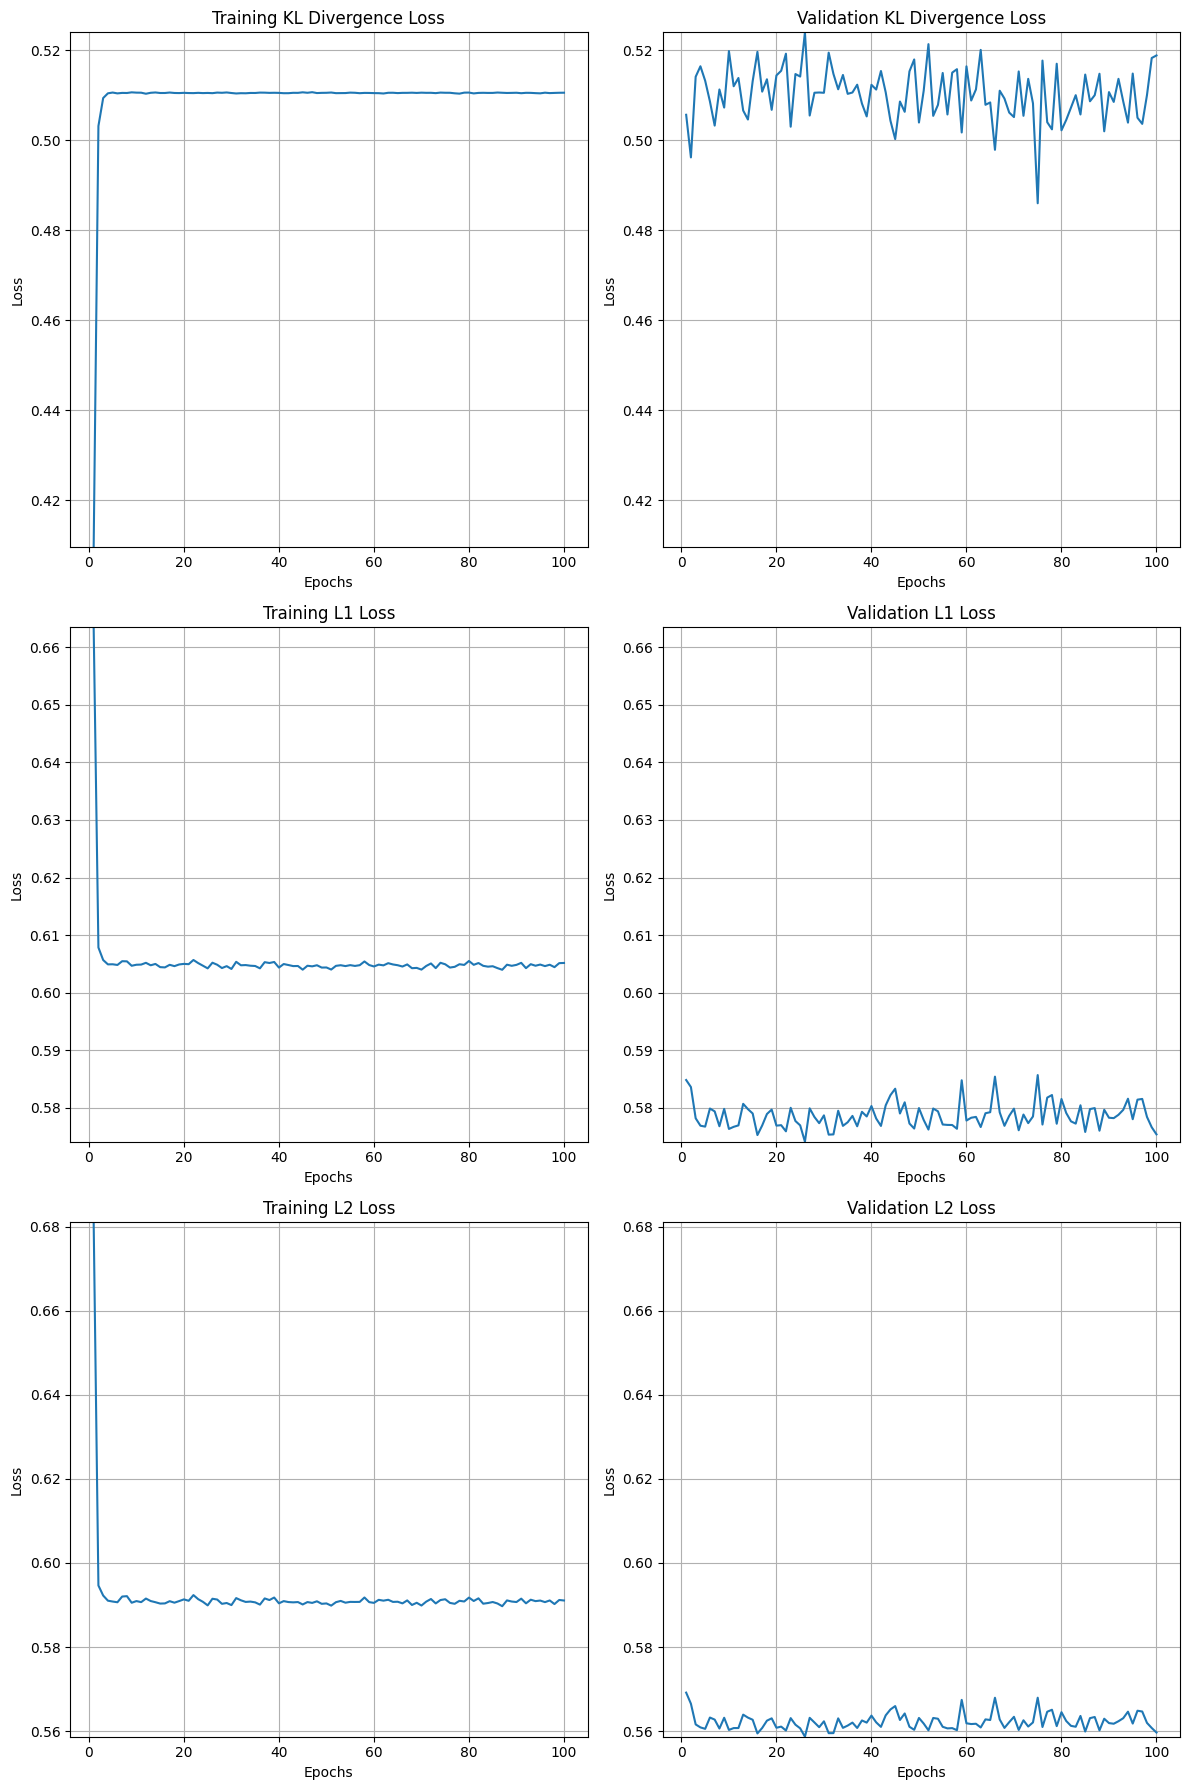

Best Validation Loss in Kelvins:
54.2935 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


z0: -0.0000
z1: -0.0548
z2: -0.0002
z3: 0.0052


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 823.47it/s]


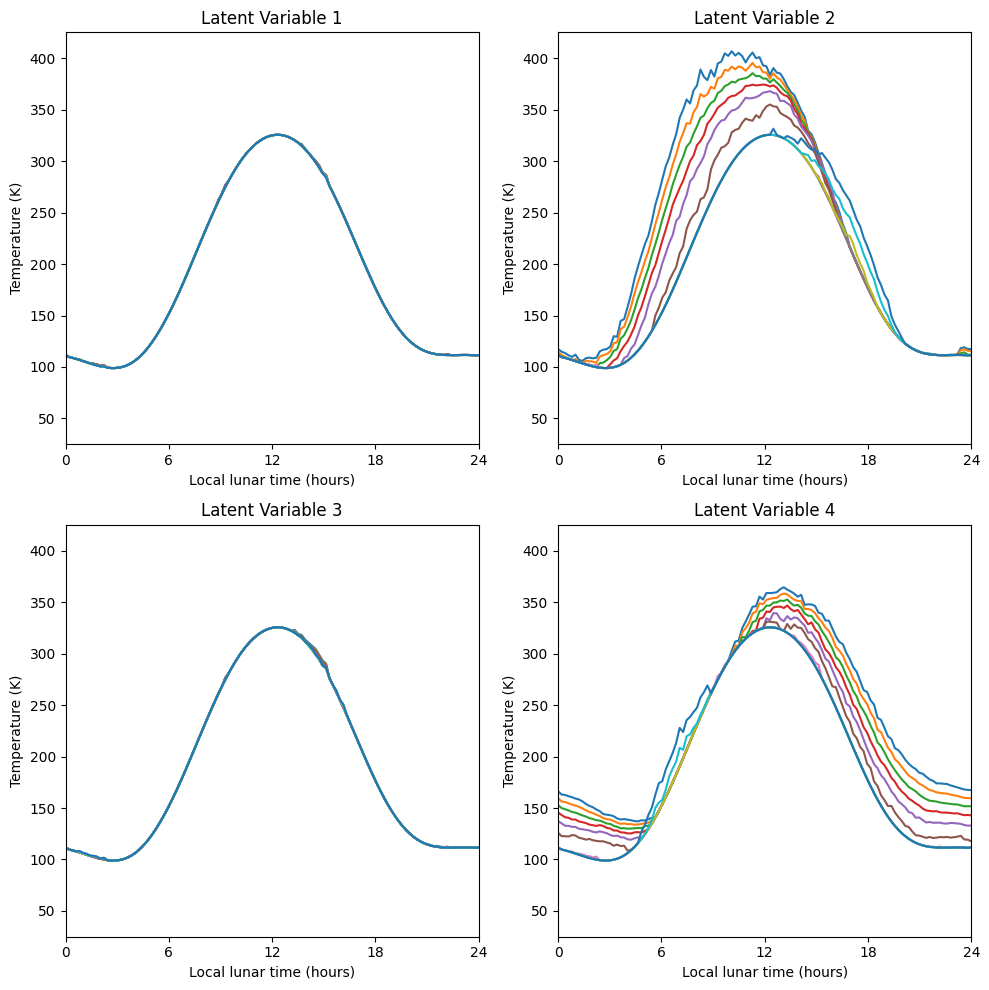

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)